## Credit Card Fraud Detection using Neural Networks


## Section 1: Introduction

This notebook demonstrates how to use machine learning techniques to detect fraudulent credit card transactions using a neural network model. The dataset is highly imbalanced, and various strategies like class balancing and cost-sensitive learning have been employed to improve the detection of fraud cases. Key features include:

- Data preprocessing (log transformation and scaling)
- Custom weighted loss function to handle class imbalance
- Cross-validation with class weight tuning
- Model evaluation using F1-score, Precision, Recall, and ROC-AUC

&nbsp;

## Section 2: Understanding the Data

The dataset used in this project contains anonymized credit card transaction data. It has `30` features, including `V1` through `V28` representing the result of a PCA transformation. Two additional features are `Amount` and `Time`. The target variable is `Class`, where `1` indicates fraud and `0` indicates non-fraud.

Due to the significant class imbalance, with fraud representing less than `0.2%` of the transactions, this presents challenges that require special handling, particularly in model evaluation.


#### Step 2.1: Import the necessary libraries

The following libraries are used for data analysis, visualization, and machine learning:
- `pandas` and `numpy` for data manipulation and numerical operations.
- `matplotlib` and `seaborn` for data visualization.
- `RandomForestClassifier` from `sklearn.ensemble` for machine learning classification.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

#### Step 2.2:  Load the dataset

The dataset used here is from the Kaggle Credit Card Fraud Detection challenge. The dataset contains anonymized features (`V1` to `V28`), `Time`, `Amount`, and a `Class` column. 
- `Class = 1` indicates a fraudulent transaction.
- `Class = 0` indicates a non-fraudulent transaction.

We load the data into a pandas DataFrame for analysis.


In [2]:
# The dataset is from Kaggle Credit Card Fraud Dataset. Please download it from: https://www.kaggle.com/mlg-ulb/creditcardfraud
df = pd.read_csv('.\data\creditcard.csv')

#### Step 2.3: Dataset dimensions

The `.shape` function will return the dimensions of the dataset in terms of rows and columns.
- Rows represent individual transactions.
- Columns represent the features, including `Class`, which indicates if the transaction is fraudulent.


In [3]:
# summary of the data set
df.shape

(284807, 31)

#### Step 2.4: Preview the dataset

We use `.head()` to display the first five rows of the dataset, which gives us an overview of the features and the structure of the data.


In [4]:
# peek the first a few data
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### Step 2.5: Count and percentage of fraudulent and non-fraudulent transactions

This step helps us understand the class distribution:
- We count the number of occurrences of `Class = 0` (non-fraudulent) and `Class = 1` (fraudulent) transactions.
- Additionally, we calculate the percentage of fraudulent transactions to understand the class imbalance.
Class imbalance can affect model performance, and it is crucial to account for it when developing machine learning models.


In [5]:
# Count the number of occurrences for each class (0 = non-fraud, 1 = fraud)
class_counts = df['Class'].value_counts()

# Print the counts for non-fraudulent (Class = 0) and fraudulent (Class = 1) transactions
print(class_counts)

# Separate the counts if needed
count_non_fraud = class_counts[0]  # Count of non-fraudulent transactions (Class = 0)
count_fraud = class_counts[1]      # Count of fraudulent transactions (Class = 1)

print(f"Non-Fraudulent Transactions (0): {count_non_fraud}")
print(f"Fraudulent Transactions (1): {count_fraud}")

# Calculate and print the percentage of fraudulent transactions
percentage_fraud = (count_fraud / len(df)) * 100
print(f"Percentage of Fraudulent Transactions: {percentage_fraud:.4f}%")

0    284315
1       492
Name: Class, dtype: int64
Non-Fraudulent Transactions (0): 284315
Fraudulent Transactions (1): 492
Percentage of Fraudulent Transactions: 0.1727%


#### Step 2.6 Check for missing values

In this step, we check whether the dataset contains any missing values. Missing values can impact the performance of machine learning models and may need to be handled by either removing or imputing them. 
- The `.isnull().sum()` function helps us identify the number of missing values in each column.


In [6]:
# Check for missing values
print(df.isnull().sum())

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


#### Step 2.7 Display the Min and Max values for each column

In this step, we loop through all the columns of the dataset to check the minimum and maximum values for each feature.
- Understanding the range of values for each column helps assess whether scaling is needed during preprocessing.
- This information is especially useful for models like logistic regression, neural networks, and support vector machines, where scaling can impact performance.

By checking the `min()` and `max()` values of each column, we can identify potential outliers or abnormalities in the data.


In [7]:
# Display the min and max values for each column
for column in df.columns:
    print(f"Column: {column}, Min: {df[column].min()}, Max: {df[column].max()}")

Column: Time, Min: 0.0, Max: 172792.0
Column: V1, Min: -56.407509631329, Max: 2.45492999121121
Column: V2, Min: -72.7157275629303, Max: 22.0577289904909
Column: V3, Min: -48.3255893623954, Max: 9.38255843282114
Column: V4, Min: -5.68317119816995, Max: 16.8753440335975
Column: V5, Min: -113.743306711146, Max: 34.8016658766686
Column: V6, Min: -26.1605059358433, Max: 73.3016255459646
Column: V7, Min: -43.5572415712451, Max: 120.589493945238
Column: V8, Min: -73.2167184552674, Max: 20.0072083651213
Column: V9, Min: -13.4340663182301, Max: 15.5949946071278
Column: V10, Min: -24.5882624372475, Max: 23.7451361206545
Column: V11, Min: -4.79747346479757, Max: 12.0189131816199
Column: V12, Min: -18.6837146333443, Max: 7.8483920756446
Column: V13, Min: -5.79188120632084, Max: 7.12688295859376
Column: V14, Min: -19.2143254902614, Max: 10.5267660517847
Column: V15, Min: -4.49894467676621, Max: 8.87774159774277
Column: V16, Min: -14.1298545174931, Max: 17.3151115176278
Column: V17, Min: -25.1627993

##### Summary of Min and Max Values for Each Feature

The results from the above cell provide a quick overview of the minimum and maximum values for each feature in the dataset. Here are the key points:

- **Time**: Ranges from 0 to 172,792, indicating that transactions span a significant time period. The 'Time' column represents the seconds elapsed between each transaction and the first transaction in the dataset.
  
- **V1 to V28**: These columns are the principal components derived from a PCA (Principal Component Analysis) transformation, and they have varying ranges:
  - Some columns like **V2**, **V5**, **V7**, **V20**, and **V28** have quite large negative and positive ranges, indicating strong variation in these principal components.
  - Others like **V24**, **V26**, and **V13** have smaller ranges, indicating less variability.
  
- **Amount**: Represents the transaction amounts, ranging from $0 to $25,691.16. This confirms the wide range of transaction amounts in the dataset.
  
- **Class**: This is the target variable, where `0` represents non-fraudulent transactions, and `1` represents fraudulent ones. The minimum value is 0, and the maximum is 1, confirming the binary classification nature of this problem.

##### Key Observations:
- The dataset appears to be preprocessed and transformed, especially with the PCA-derived components (**V1-V28**).
- There is significant variation in the range of values across the different columns.
- Some of the principal components (e.g., **V5**, **V7**, **V20**) have wide ranges, which could be indicative of their importance in distinguishing between fraudulent and non-fraudulent transactions.


&nbsp;

#### Step 2.8 Exploratory Data Analysis: Statistical Summary

We will begin our exploratory data analysis by generating a statistical summary of the dataset. This includes details such as the count, mean, standard deviation, and percentiles for each feature in the dataset.

The `df.describe()` method helps us get a sense of the central tendency, spread, and shape of the dataset's distribution, which will guide us in identifying potential areas for further analysis, including outliers.


In [8]:
# Exploratory Data Analysis
# This will give a statistical summary of the dataset, including count, mean, standard deviation, min, max, and quantiles for numerical columns.
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


&nbsp;

#### Step 2.9 Visualizing Data Distributions: Histograms

Next, we visualize the distributions of the dataset's features using histograms. This allows us to explore the frequency of values for each feature and identify any patterns, skewness, or potential outliers.

Each feature is plotted on an individual histogram, and we can visually inspect how the data is distributed across different ranges.



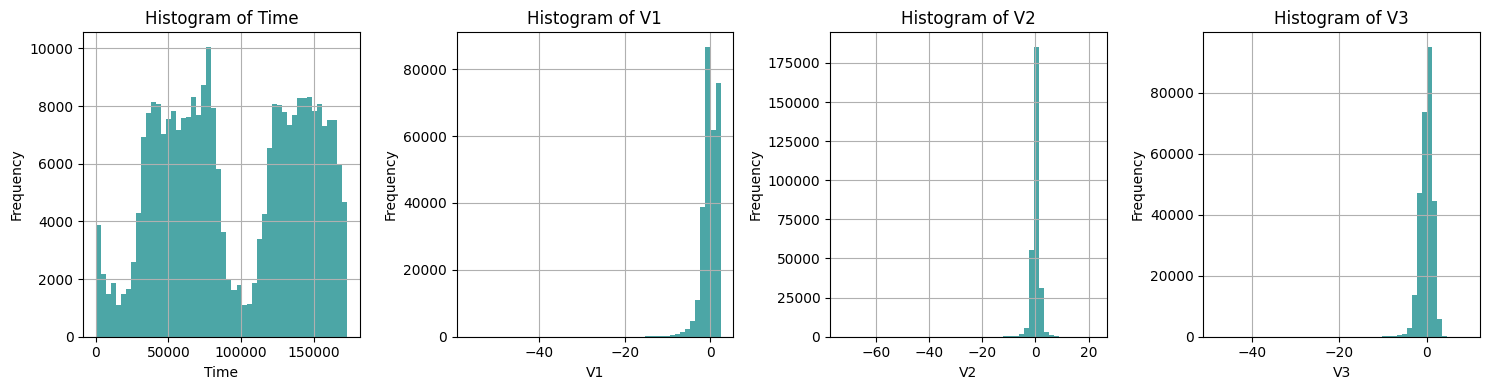

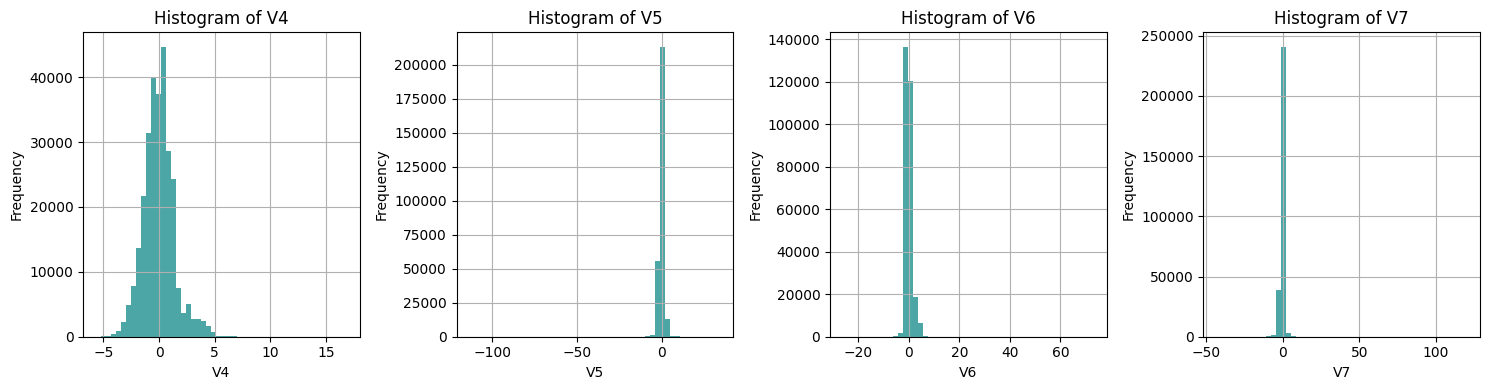

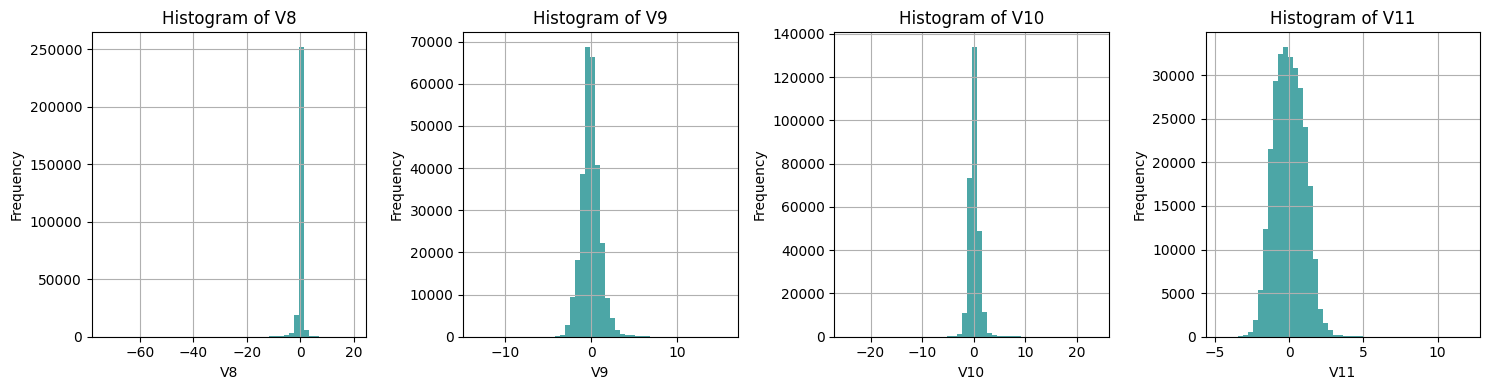

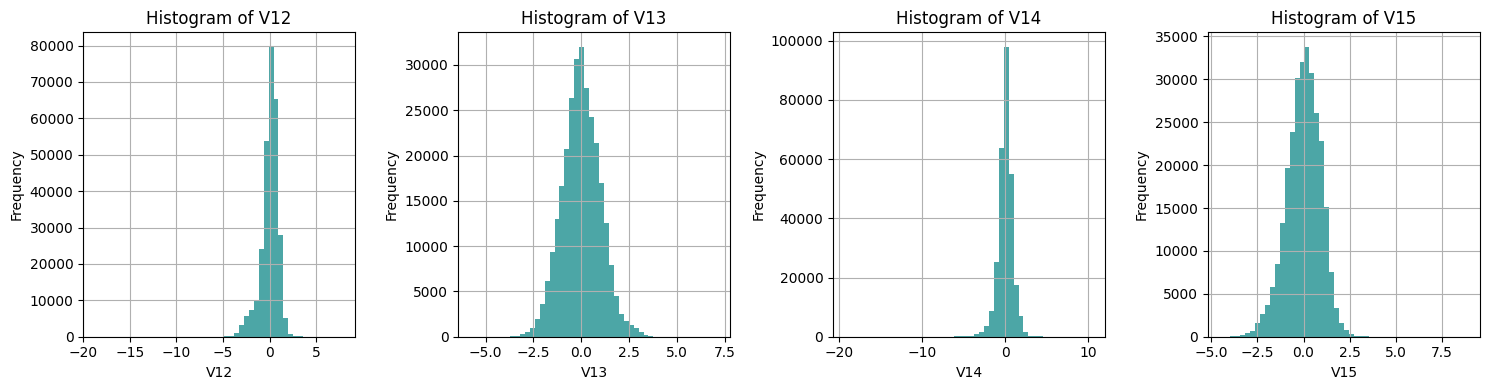

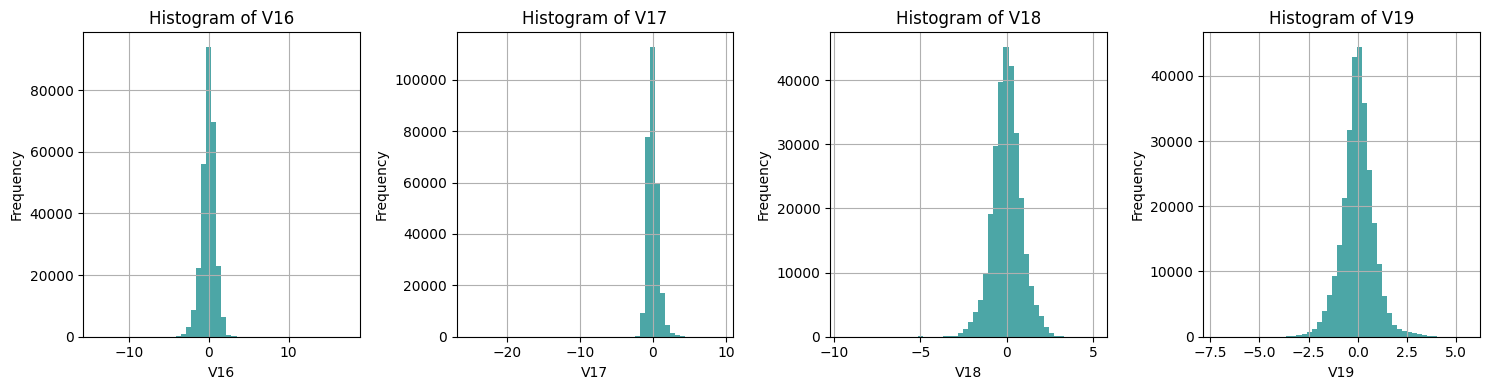

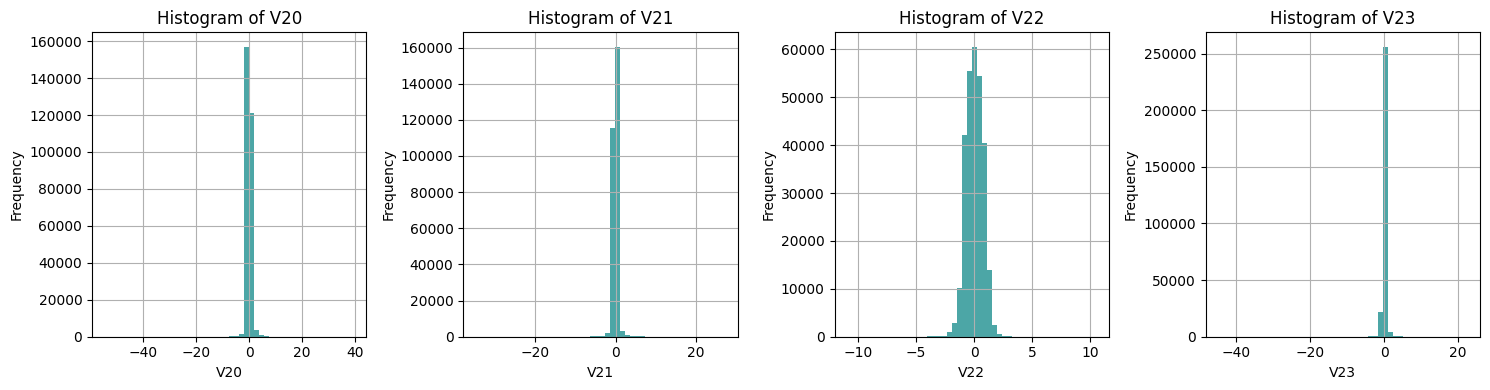

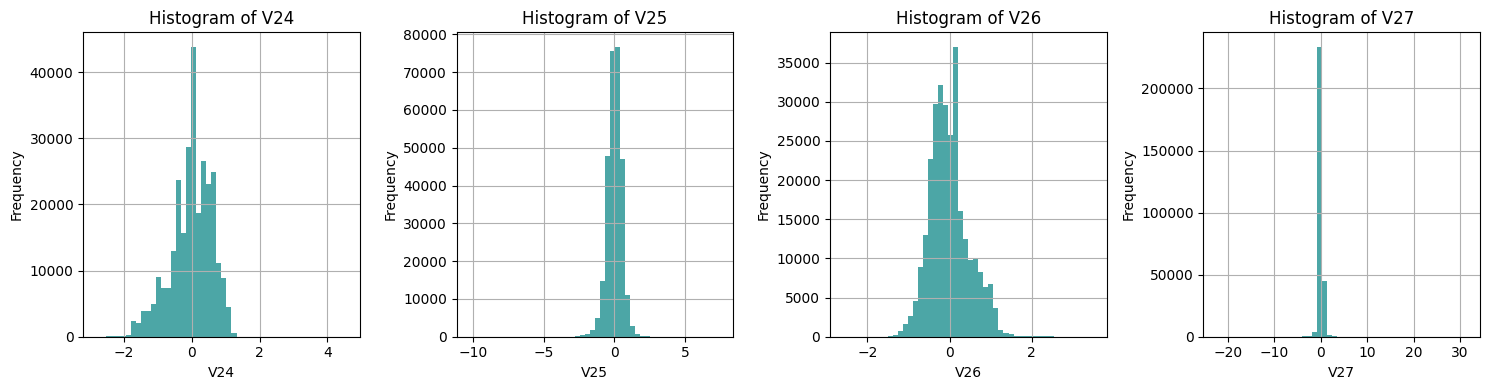

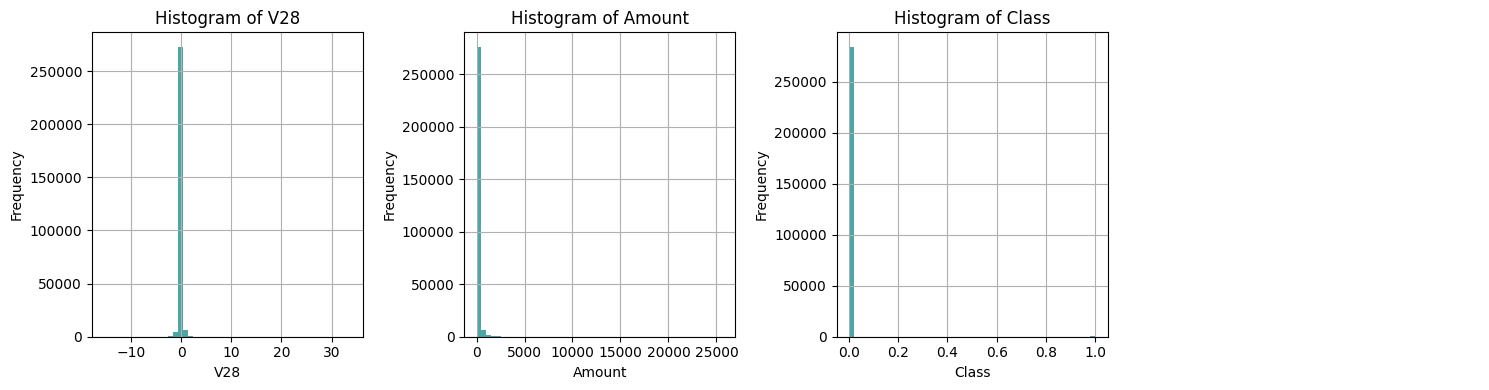

In [9]:
# View histogram data
# Get the list of columns
columns = df.columns

# Loop through the columns in groups of 4
for i in range(0, len(columns), 4):
    # Create a subplot with 1 row and 4 columns, each with an independent y-axis
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))

    # Plot the first four columns in the group
    for j in range(4):
        if i + j < len(columns):
            axes[j].hist(df[columns[i + j]], bins=50, color='teal', alpha=0.7)
            axes[j].set_title(f"Histogram of {columns[i + j]}")
            axes[j].set_xlabel(columns[i + j])
            axes[j].set_ylabel("Frequency")
            axes[j].grid(True)
        else:
            # If there is no column for this plot, hide the subplot
            axes[j].axis('off')

    # Show the plot
    plt.tight_layout()
    plt.show()
    plt.close()  # Close the plot to free up memory


##### Review of Histogram Plots

The histogram plots provide an important visual summary of the distribution of the features in the dataset. Upon reviewing the plots, we observe the following:

- Most of the features, particularly those labeled V1 to V28, represent principal components derived from the original data and appear to be centered around zero, exhibiting various distributions.
- **V2, V5, V6, V7, V8, V20, V21, V23, V27, V28, "Amount", and "Class"** are notable for not being normally distributed, displaying skewness or irregular patterns. This suggests the possibility of outliers or inherent characteristics of the transactions in these features.
- The **"Class"** feature, which represents fraud or non-fraud transactions, is highly imbalanced, as expected.
- The **"Amount"** feature shows a right-skewed distribution, indicating that most transactions involve small amounts, with a few larger transactions.

These irregularities or skewness in the data could indicate potential outliers or structural differences in transaction behavior. In the next steps, we will need to further analyze outliers and potentially apply transformations or scaling to make the data more suitable for machine learning algorithms.


&nbsp;

#### Step 2.10 Detecting Outliers Using the IQR Method

Outliers are data points that deviate significantly from other observations in the dataset. Identifying outliers is crucial because they can potentially distort the results of machine learning algorithms. One common method to detect outliers is the **Interquartile Range (IQR) method**.

##### Interquartile Range (IQR)
The IQR is a measure of statistical dispersion and is calculated as the difference between the 75th and 25th percentiles (Q3 and Q1, respectively):

IQR = Q3 - Q1

Using the IQR, we define outliers as points that fall below the lower bound or above the upper bound:
- **Lower Bound**: Q1 - 1.5 * IQR
- **Upper Bound**: Q3 + 1.5 * IQR

##### Process:
1. **Q1 (25th percentile)** and **Q3 (75th percentile)** are calculated for each numeric feature.
2. **Lower Bound**: Any value below Q1 - 1.5 * IQR is considered an outlier.
3. **Upper Bound**: Any value above Q3 + 1.5 * IQR is considered an outlier.
4. We count the number of outliers for each feature and calculate the percentage of outliers relative to the total number of records in the dataset.
5. The features are sorted based on the percentage of outliers in descending order to identify the features with the highest proportion of outliers.

Features with a high percentage of outliers may require further analysis, and in some cases, we may consider transformations, scaling, or removing the outliers.

##### Results:
The table below shows the number and percentage of outliers for each feature in the dataset:


In [10]:
# Dictionary to store outlier information
outlier_info = {}

# Detecting outliers using IQR method for numerical features
numeric_columns = df.select_dtypes(include=[np.number]).columns
total_rows = len(df)

for column in numeric_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate the lower and upper bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count outliers
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    num_outliers = len(outliers)
    percentage_outliers = (num_outliers / total_rows) * 100
    
    # Store the number of outliers and percentage in the dictionary
    outlier_info[column] = {
        "num_outliers": num_outliers,
        "percentage_outliers": percentage_outliers
    }

# Sort the dictionary by the percentage of outliers in descending order
sorted_outliers = sorted(outlier_info.items(), key=lambda x: x[1]['percentage_outliers'], reverse=True)

# Display the results
print(f"{'Feature':<20} {'Num Outliers':<15} {'% Outliers':<15}")
print("=" * 50)
for feature, info in sorted_outliers:
    print(f"{feature:<20} {info['num_outliers']:<15} {info['percentage_outliers']:<15.2f}")


Feature              Num Outliers    % Outliers     
V27                  39163           13.75          
Amount               31904           11.20          
V28                  30342           10.65          
V20                  27770           9.75           
V8                   24134           8.47           
V6                   22965           8.06           
V23                  18541           6.51           
V12                  15348           5.39           
V21                  14497           5.09           
V14                  14149           4.97           
V2                   13526           4.75           
V5                   12295           4.32           
V4                   11148           3.91           
V19                  10205           3.58           
V10                  9496            3.33           
V7                   8948            3.14           
V9                   8283            2.91           
V16                  8184            2.87     

&nbsp;

#### Step 2.11 Correlation of Outliers with Fraud Cases

After identifying the presence of outliers in various features, it's important to investigate whether these outliers are associated with fraudulent transactions. Outliers may provide significant information as fraudulent transactions can deviate significantly from normal patterns.

To explore this, we can calculate the percentage of fraud cases among the detected outliers in each feature. By doing this, we aim to understand if outliers in certain features are more strongly associated with fraud compared to non-outliers.

##### Key Insights:
- Features with a higher percentage of fraud cases among their outliers may indicate that these features play a critical role in detecting fraud.
- If a feature has a high correlation between its outliers and fraud cases, it suggests that this feature could be crucial in identifying potential fraudulent transactions.
- Conversely, features with a low percentage of fraud cases among outliers may indicate that their outliers do not contribute significantly to fraud detection, and we might consider treating or removing such outliers to improve model performance.

The next steps would involve handling these outliers through techniques such as:
1. **Removing Outliers**: Discarding the detected outliers, especially in features where outliers have a low correlation with fraud.
2. **Transforming Features**: Applying techniques like log transformation or scaling to reduce the impact of outliers while preserving valuable information.
3. **Keeping Outliers**: In cases where the outliers are strongly associated with fraud, we might retain these outliers as they could be essential for model accuracy in fraud detection.


In [11]:
# Check for the correlation of outliers with fraud cases for each feature
outlier_fraud_correlation = []

# Loop through each feature
for column in df.columns[:-1]:  # Exclude the 'Class' column
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Get outliers for the current column
    is_outlier = (df[column] < lower_bound) | (df[column] > upper_bound)

    # Check how many fraud cases are in the outliers
    fraud_cases_in_outliers = df[is_outlier & (df['Class'] == 1)]
    non_fraud_cases_in_outliers = df[is_outlier & (df['Class'] == 0)]

    # Calculate the percentage of fraud cases among outliers
    total_outliers = len(df[is_outlier])
    fraud_percentage_in_outliers = (len(fraud_cases_in_outliers) / total_outliers) * 100 if total_outliers > 0 else 0

    # Append the result to the list
    outlier_fraud_correlation.append({
        'Feature': column,
        'Fraud Cases in Outliers': len(fraud_cases_in_outliers),
        'Non-Fraud Cases in Outliers': len(non_fraud_cases_in_outliers),
        'Total Outliers': total_outliers,
        'Percentage Fraud in Outliers': fraud_percentage_in_outliers
    })

# Convert to DataFrame to display the results
outlier_fraud_df = pd.DataFrame(outlier_fraud_correlation)
outlier_fraud_df = outlier_fraud_df.sort_values(by='Percentage Fraud in Outliers', ascending=False)

# Display the result
print(outlier_fraud_df)


   Feature  Fraud Cases in Outliers  Non-Fraud Cases in Outliers  \
11     V11                      294                          486   
3       V3                      312                         3051   
17     V17                      397                         7023   
16     V16                      351                         7833   
10     V10                      399                         9097   
7       V7                      301                         8647   
18     V18                      237                         7296   
14     V14                      430                        13719   
4       V4                      318                        10830   
9       V9                      223                         8060   
12     V12                      409                        14939   
1       V1                      174                         6888   
22     V22                       28                         1289   
2       V2                      246             

##### Key Observations Based on Outlier and Fraud Correlation:

1. **Class Feature**:
   - The `Class` feature itself has 492 fraud cases, which aligns with the total number of fraud cases in the dataset (100% of fraud cases are in this "outlier" feature, which makes sense because this feature directly indicates fraud or non-fraud transactions).

2. **Top Features with Higher Fraud Outliers**:
   - **V11** shows the highest percentage of fraud cases among its outliers (37.69%), indicating that it might be a critical feature for fraud detection.
   - Features such as **V3**, **V17**, **V16**, and **V10** also show noticeable percentages of fraud cases in their outliers, suggesting that outliers in these features could be indicative of fraudulent behavior.

3. **Features with Lower Fraud Outliers**:
   - Many features (e.g., **Amount**, **V28**, **V27**) have large numbers of outliers, but the percentage of fraud cases among these outliers is quite low. For example, **Amount** has 31,904 outliers, but only 0.28% of these outliers are associated with fraud cases.
   - Similarly, **V27** and **V28** have a large number of outliers, but a low percentage of fraud cases (less than 1%).

4. **Features with No or Very Few Outliers**:
   - Some features, such as **Time** and **V24**, have no or very few outliers and no correlation with fraud cases.

##### Insights and Next Steps:
- **High Fraud Outliers (e.g., V11, V3, V17)**: These features may contain strong signals related to fraud detection, particularly among their outliers. It could be beneficial to further investigate the behavior of these features (e.g., distribution analysis, transformation, scaling).
  
- **Low Fraud Outliers (e.g., Amount, V28, V27)**: Even though these features have a large number of outliers, their correlation with fraud is low. These features may benefit from different preprocessing techniques such as scaling, transformation, or even removal of outliers.

- **Features with Very Few or No Outliers**: For features with very few outliers or none (such as **Time** and **V24**), it’s likely that no further outlier handling is necessary.

- **Handling Outliers**: Features with high fraud correlation in their outliers (such as **V11** or **V3**) could be explored further, possibly retaining their outliers for model training. On the other hand, features with low fraud correlation might have their outliers removed.

##### Conclusion:
This analysis provides valuable insights into the correlation between outliers and fraud cases. Based on these insights, we can make informed decisions on how to handle outliers for the next steps in data preprocessing, including normalization, scaling, or outlier removal, to improve the performance of machine learning models.


&nbsp;

## Section 3: Preprocessing the Data

In this section, we apply important preprocessing steps to prepare the dataset for modeling. These steps include:

1. **Feature Scaling**: We use `RobustScaler` to normalize the feature values. This scaler is robust to outliers and scales the data by removing the median and scaling according to the interquartile range (IQR).
2. **Handling Class Imbalance**: The dataset is highly imbalanced with significantly more non-fraudulent transactions than fraudulent ones. To address this, we apply `SMOTE` (Synthetic Minority Over-sampling Technique) after scaling to create synthetic samples for the minority class (fraud cases). This balances the dataset for better model performance.
3. **Train-Test Split**: The dataset is split into training and test sets using `train_test_split`, with 80% of the data used for training and 20% reserved for testing. The split is stratified to maintain the proportion of fraud and non-fraud cases in both sets.


### Step 3: Preprocessing Data

#### Purpose
The preprocessing step is crucial for preparing the data before training the model. Given the highly imbalanced nature of the dataset, special attention is needed to handle the skew between non-fraud and fraud transactions. Instead of oversampling using methods like SMOTE, we have opted for downsampling the majority class (non-fraud) to achieve a 2:1 ratio of non-fraud to fraud cases. Additionally, feature engineering and scaling are applied to improve model performance.

#### Methods

1. **Log Transformation of the `Amount` Feature:**
   - The `Amount` feature represents the transaction amount, which varies widely across transactions. To reduce the impact of outliers and skewed distributions, we apply a log transformation to the `Amount` feature. This helps normalize its distribution and stabilize variance.

2. **Feature Extraction - `Hour` Feature:**
   - The dataset contains a `Time` feature that records the time elapsed since the first transaction in the dataset. We extract the `Hour` component from the `Time` feature to capture potential hourly patterns in fraud activity.

3. **Downsampling to Handle Class Imbalance:**
   - The dataset is highly imbalanced, with fraudulent transactions making up less than 0.2% of the total. To address this, we downsample the majority class (non-fraud transactions) to create a balanced dataset with a 2:1 ratio of non-fraud to fraud cases. This helps the model focus on detecting fraud without being overwhelmed by the majority class.

4. **Splitting Data:**
   - After downsampling, the data is split into training and test sets with an **80:20 ratio**, where 80% of the total dataset is used for training and 20% for final testing. Stratified splitting ensures that the class distribution is maintained in both sets.
   - In addition, a **60:40 split** is applied to the training set during cross-validation, where **40%** of the training data is used for training and **60%** is reserved for validation. This cross-validation setup ensures that the model performs well on unseen data and can generalize to the final test set (20% of the original dataset).

5. **Scaling Features:**
   - We use the `RobustScaler` to scale the features, as this scaler is less sensitive to outliers compared to standard scaling methods. This is particularly useful when dealing with real-world financial transaction data, where extreme values are common.

#### Post-Preprocessing Summary:
- After downsampling, the dataset is more balanced, with a non-fraud to fraud ratio of 2:1.
- The data has been split into training and test sets with an **80:20 ratio**, where **80%** of the total dataset is used for training, and **20%** is used for final testing.
- Cross-validation involves a **60:40 split** within the training set to validate model performance, ensuring the model performs consistently on the original test data.
- The features have been scaled using `RobustScaler` to ensure that the model can learn efficiently without being impacted by large variations in feature magnitudes.

By applying these preprocessing steps, we aim to improve the neural network's ability to accurately detect fraud in credit card transactions while mitigating the effects of class imbalance and feature distribution skewness.


&nbsp;

## Section 4: Build the Neural Network

### Step 4: Credit Card Fraud Detection using Neural Networks and Class Balancing

#### Purpose
The goal of this project is to build a neural network model to accurately detect credit card fraud from highly imbalanced data. Fraudulent transactions represent a very small percentage of the dataset (less than 0.2%), posing challenges for detecting true positives (fraud) while minimizing false positives.

#### Methods
1. **Data Preprocessing:**
   - The dataset is downsampled to achieve a 2:1 ratio between non-fraud and fraud cases.
   - The features are scaled using `RobustScaler`, and the data is split into training and test sets.

2. **Neural Network Architecture:**
   - The model is a Sequential neural network with multiple layers:
     - Dense and Dropout layers to prevent overfitting.
     - `relu` activation for hidden layers and `sigmoid` activation for the binary output.
   - The network is compiled with the `Adam` optimizer and `binary_crossentropy` loss.

3. **Cross-Validation for Optimal Class Weights:**
   - To handle class imbalance, various class weights are tested during training.
   - A stratified cross-validation process selects the class weight that yields the best **F1 score** for fraud detection.

4. **Final Model Training:**
   - The final model is trained using the optimal class weight found during cross-validation, for 15 epochs with early stopping and learning rate reduction.

5. **Model Evaluation:**
   - The model is evaluated on the test set using key metrics:
     - **F1 score**, **precision**, **recall**, **ROC-AUC score**, and **confusion matrix**.
     - A detailed **Classification Report** summarizes the performance for both non-fraud and fraud classes.

#### Technical Details
- **Class Imbalance Handling:** The dataset's natural imbalance (with fraud cases less than 0.2%) is addressed by downsampling the non-fraud cases to a 2:1 ratio, ensuring that the model has more balanced exposure to both classes.
- **Model Configuration:** The neural network leverages `Adam` for optimization and uses `binary_crossentropy` for loss calculation. Dense and dropout layers are employed to enhance generalization and avoid overfitting.
- **Model Optimization:** A cross-validation mechanism is employed to fine-tune class weights, with an emphasis on maximizing the F1 score for fraud detection.
- **Training and Evaluation:** Early stopping and learning rate scheduling are employed to prevent overfitting, and key metrics like the confusion matrix and ROC-AUC are used to evaluate performance.



&nbsp;

TensorFlow version: 2.10.0
GPUs detected: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')

Overall Model Training and Tuning Start Time: 2024-10-19 23:35:29


Tuning model: 13200 configurations [8:41:42,  2.37s/ configurations, Trying=13200/13200, Class weight=2.10, F1 (Fraud)=0.9120]


Best model saved to './models/credit-card-fraud-detection-neural-network.keras'

Overall  Model Training and Tuning End Time: 2024-10-20 08:17:11
Overall training Duration: 8 hours and 521 minutes and 42 seconds

Selected Best Class Weight: 1.4100000000000004, Best Learning Rate: 0.0010000000000000002,Best Drop Rate: 0.2,Best Regulator Factor: 0.0005,
Best F1-score (Fraud) from Cross-Validation: 0.94
Best Precision (Fraud) from Cross-Validation: 0.98
Best Recall (Fraud) from Cross-Validation: 0.90

Final F1-score (Fraud) from Test data: 0.91
Final Precision (Fraud) from Test data: 0.97
Final Recall (Fraud) from Test data: 0.86
Final Model ROC-AUC Score from Test data: 0.96

Final Confusion matrix from Test data:
 [[194   3]
 [ 14  85]]

Final Model Classification Report from Test data:
               precision    recall  f1-score   support

   Non-Fraud       0.93      0.98      0.96       197
       Fraud       0.97      0.86      0.91        99

    accuracy                          

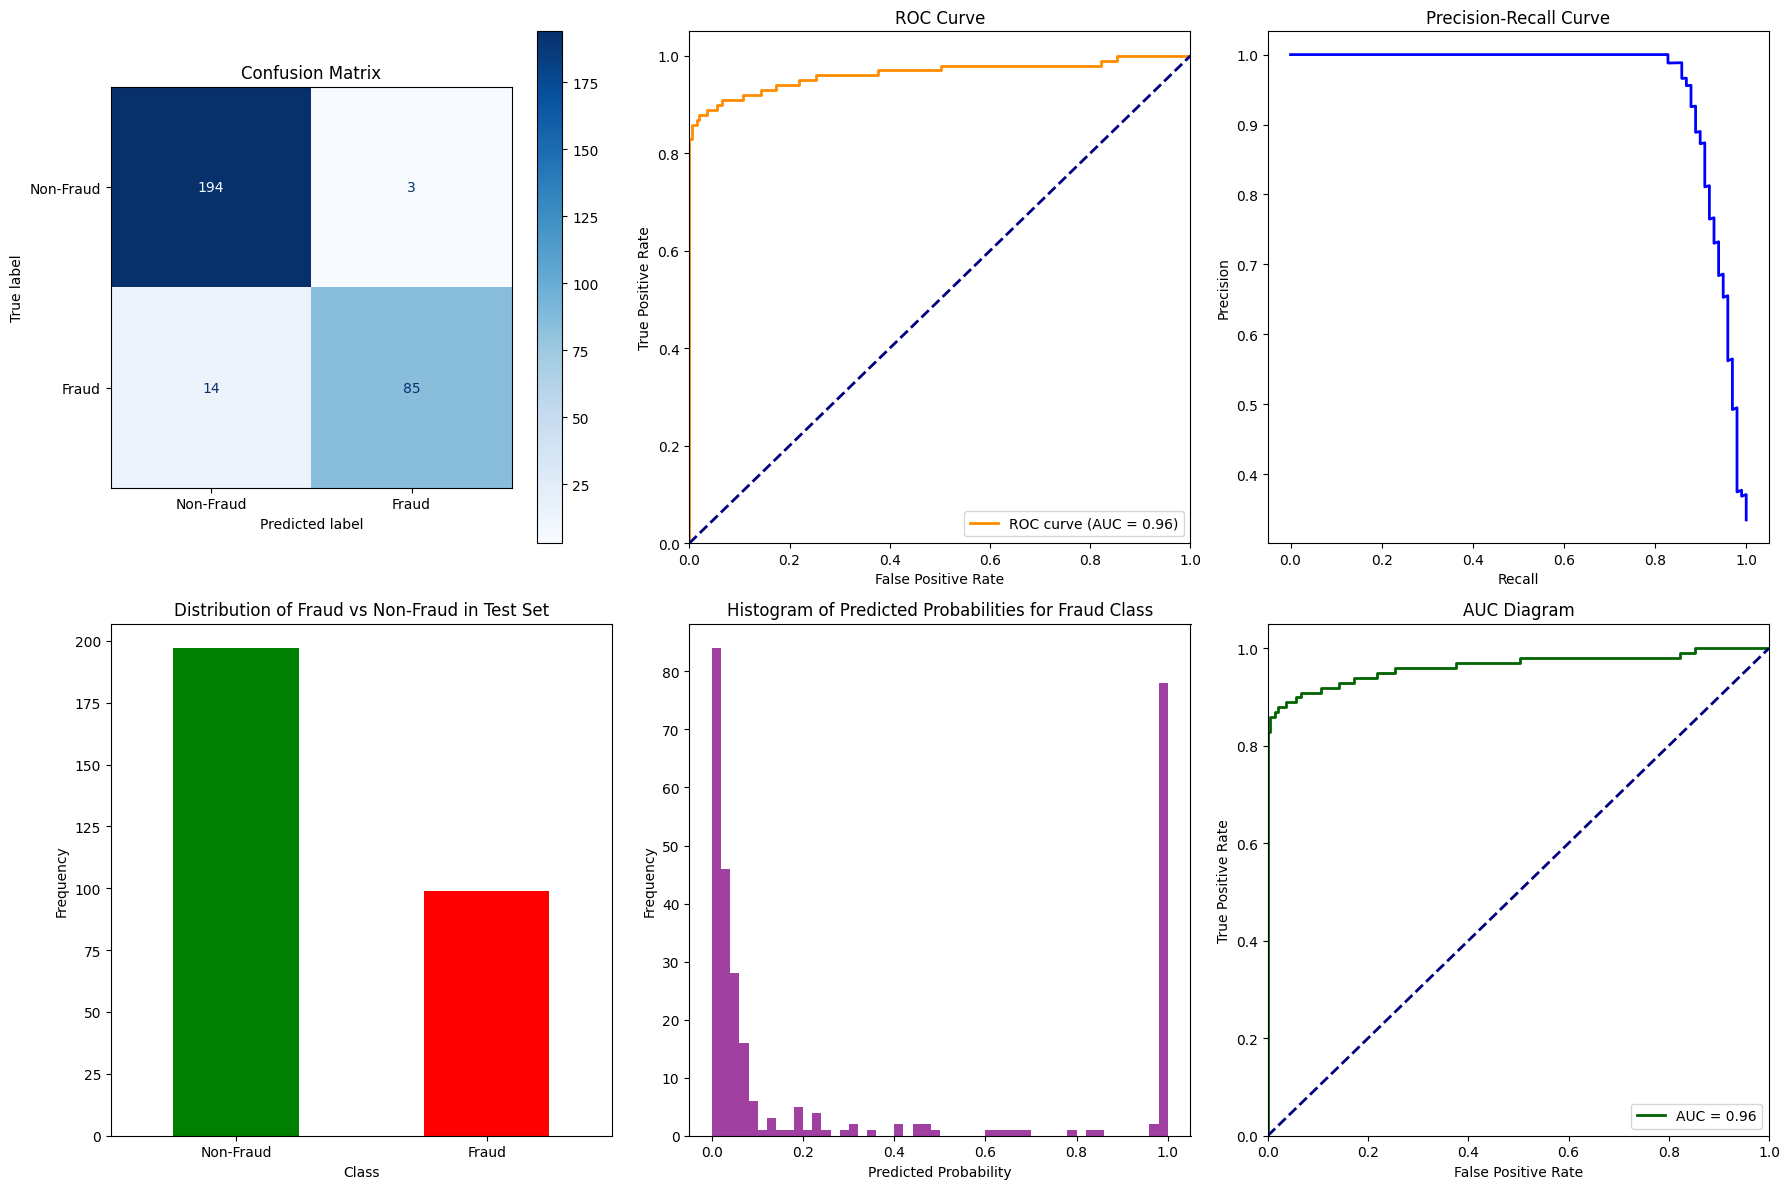

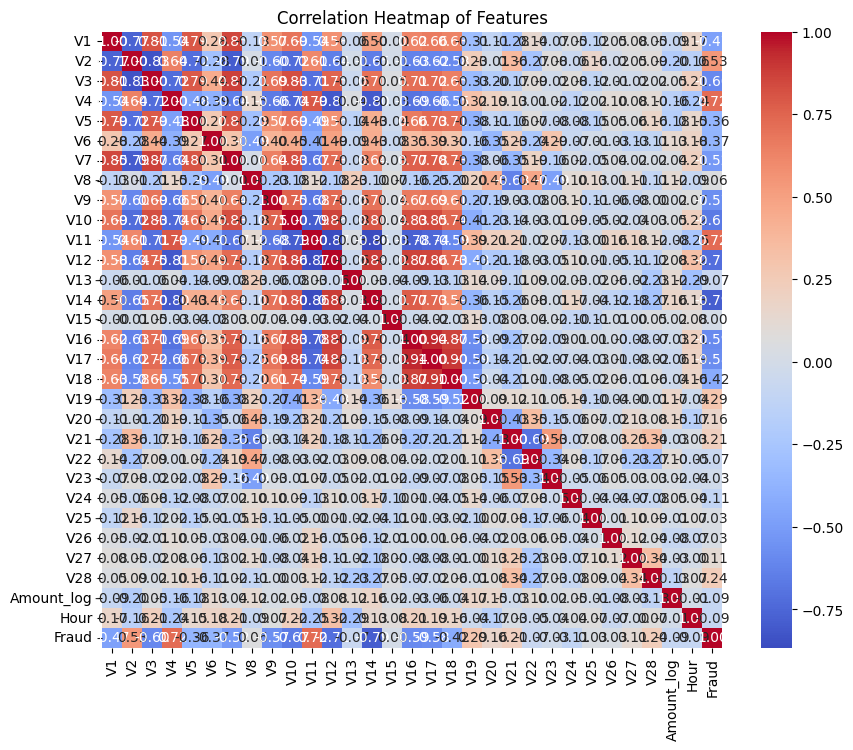

In [1]:
# Credit Card Fraud Detection Neural Network
# complete code so that this code can be executed by a single run

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm
import tensorflow as tf
import random
import time
from sklearn.utils import shuffle
import itertools
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import tensorflow.keras.backend as K
import os
from sklearn.metrics import ConfusionMatrixDisplay

# --- Step 0: fix the random states ---
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
tf.config.experimental.enable_op_determinism()

# --- Step 1: Parameter Setting ---
threshold = 0.5
non_fraud_to_fraud_sample_ratio = 2
test_size = 0.2
training_validation_test_size = 0.6 
training_epochs = 15
initial_learning_rate = 0.0009 
initial_drop_rate = 0.3 
initial_reg_factor = 0.001 

class_weights_range = np.arange(1.01, 2.11, 0.01)

# class_weights_range = np.arange(1.23, 1.2301, 0.01) # 1 loop

# normal selection for mulitple configurations tuning
learning_rate_range =  np.arange(0.0002, 0.0012, 0.0001) # 12 loops
drop_rate_range =  np.arange(0.1, 0.4, 0.1) # 4 loops
reg_factor_range =  np.arange(0.0005, 0.002, 0.0005) # 4 loops

# quick selection for a single configuration
# learning_rate_range =  np.arange(0.0009, 0.00091, 0.0001) # single loop
# drop_rate_range =  np.arange(0.3, 0.31, 0.1) # single loop
# reg_factor_range =  np.arange(0.001, 0.0011, 0.001) # single loop


# Ensure directories for saving models and plots exist
os.makedirs('models', exist_ok=True)
os.makedirs('plots', exist_ok=True)

# --- Step 2: Load Data ---
df = pd.read_csv('./data/creditcard.csv')

# --- Step 3: Preprocessing Data ---
df['Amount_log'] = np.log(df['Amount'] + 1e-5)  # Log transform of 'Amount' feature
df['Hour'] = pd.to_datetime(df['Time'], unit='s').dt.hour  # Extract hour part from datetime

# --- Downsampling the dataset to a 2:1 ratio (non-fraud : fraud) ---
fraud_cases = df[df['Class'] == 1]
non_fraud_cases = df[df['Class'] == 0]
n_fraud_cases = len(fraud_cases)
n_non_fraud_sample = n_fraud_cases * non_fraud_to_fraud_sample_ratio
non_fraud_cases_sampled = non_fraud_cases.sample(n=n_non_fraud_sample, random_state=42)

balanced_df = pd.concat([fraud_cases, non_fraud_cases_sampled])
balanced_df = shuffle(balanced_df, random_state=42)

X_balanced = balanced_df.drop(columns=['Class', 'Time', 'Amount'])
y_balanced = balanced_df['Class']

# --- Step 4: Splitting Data ---
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=test_size, random_state=42, stratify=y_balanced)

scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# --- Function Definitions ---
def build_model(learning_rate=initial_learning_rate, drop_rate=initial_drop_rate, reg_factor=initial_reg_factor, seed=42):
    n_inputs = X_train_scaled.shape[1]
    model = Sequential([
        Dense(n_inputs, input_shape=(n_inputs,), activation='relu'),
        Dropout(drop_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(reg_factor)),
        Dropout(drop_rate),
        Dense(32, activation='relu', kernel_regularizer=l2(reg_factor)),
        Dropout(drop_rate),
        Dense(1, activation='sigmoid')  # Binary classification
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])
    return model

def cross_validate_class_weight(X_train, y_train, class_weights_range, learning_rate_range, drop_rate_range, reg_factor_range):
    best_class_weight = None
    best_learning_rate = None
    best_drop_rate = None
    best_reg_factor = None
    
    best_f1_score = 0
    best_precision = 0
    best_recall = 0
    best_model = None

    # Split the training data into a training set and a validation set
    X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
        X_train, y_train, test_size=training_validation_test_size, random_state=42, stratify=y_train
    )

    total_iterations = len(class_weights_range) * len(learning_rate_range) * len(drop_rate_range) * len(reg_factor_range)
    progress_bar = tqdm(total_iterations, desc="Tuning model", ncols=100, unit=" configurations")

    idx = 0
    for class_weight in class_weights_range:  # Iterate over class weight ranges
        for learning_rate in learning_rate_range:  # Iterate over learning rate ranges
            for drop_rate in drop_rate_range:  # Iterate over drop rate ranges
                for reg_factor in reg_factor_range:  # Iterate over reg factor ranges
                    idx = idx + 1
                    tf.keras.backend.clear_session()  # Clear session to reset model
            
                    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
                    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
            
                    model = build_model(learning_rate, drop_rate, reg_factor,42)
                    model.fit(X_train_split, y_train_split, epochs=training_epochs, batch_size=32, verbose=0, 
                              class_weight={0: 1, 1: class_weight}, validation_data=(X_val_split, y_val_split), callbacks=[reduce_lr, early_stopping])
            
                    y_val_pred_probs = model.predict(X_val_split, verbose=0)
                    y_val_pred_classes = (y_val_pred_probs > threshold).astype("int32")
            
                    val_f1 = f1_score(y_val_split, y_val_pred_classes, pos_label=1)
                    val_precision = classification_report(y_val_split, y_val_pred_classes, output_dict=True)['1']['precision']
                    val_recall = classification_report(y_val_split, y_val_pred_classes, output_dict=True)['1']['recall']

                    # Add a sleep interval to allow GPU to cool down
                    time.sleep(0.5)

                    # Update progress bar with the current step
                    progress_bar.update(1)
                    progress_bar.set_postfix({"Trying": f"{idx}/{total_iterations}", "Class weight": f"{class_weight:.2f}", "F1 (Fraud)": f"{val_f1:.4f}"})
   
                    if val_f1 > best_f1_score:
                        best_model = model
                        best_f1_score = val_f1
                        best_precision = val_precision
                        best_recall = val_recall
                        best_class_weight = class_weight
                        best_learning_rate = learning_rate
                        best_drop_rate = drop_rate
                        best_reg_factor = reg_factor

    # Save the best model
    best_model.save('./models/credit-card-fraud-detection-neural-network.keras')

    print("Best model saved to './models/credit-card-fraud-detection-neural-network.keras'")

    return best_class_weight, best_learning_rate, best_drop_rate, best_reg_factor, best_f1_score, best_precision, best_recall, best_model

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=cmap)
    plt.title(title)
    plt.show()
    
def plot_results(y_test, y_pred_probs, y_pred_classes, conf_matrix, X_test_scaled, X):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # 2x3 grid for the first six plots

    # 1. Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Non-Fraud', 'Fraud'])
    disp.plot(cmap=plt.cm.Blues, ax=axes[0, 0], values_format='d')
    axes[0, 0].set_title('Confusion Matrix')

    # 2. ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    axes[0, 1].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    axes[0, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0, 1].set_xlim([0.0, 1.0])
    axes[0, 1].set_ylim([0.0, 1.05])
    axes[0, 1].set_xlabel('False Positive Rate')
    axes[0, 1].set_ylabel('True Positive Rate')
    axes[0, 1].set_title('ROC Curve')
    axes[0, 1].legend(loc="lower right")

    # 3. Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
    axes[0, 2].plot(recall, precision, lw=2, color='blue')
    axes[0, 2].set_xlabel('Recall')
    axes[0, 2].set_ylabel('Precision')
    axes[0, 2].set_title('Precision-Recall Curve')

    # 4. Distribution of Fraud vs Non-Fraud in Test Set
    y_test.value_counts().plot(kind='bar', color=['green', 'red'], ax=axes[1, 0])
    axes[1, 0].set_title('Distribution of Fraud vs Non-Fraud in Test Set')
    axes[1, 0].set_xlabel('Class')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_xticks([0, 1])
    axes[1, 0].set_xticklabels(['Non-Fraud', 'Fraud'], rotation=0)

    # 5. Histogram of Predicted Probabilities for Fraud Class
    axes[1, 1].hist(y_pred_probs, bins=50, color='purple', alpha=0.75)
    axes[1, 1].set_title('Histogram of Predicted Probabilities for Fraud Class')
    axes[1, 1].set_xlabel('Predicted Probability')
    axes[1, 1].set_ylabel('Frequency')

    # 6. AUC Plot
    axes[1, 2].plot(fpr, tpr, color='darkgreen', lw=2, label=f'AUC = {roc_auc:.2f}')
    axes[1, 2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1, 2].set_xlim([0.0, 1.0])
    axes[1, 2].set_ylim([0.0, 1.05])
    axes[1, 2].set_xlabel('False Positive Rate')
    axes[1, 2].set_ylabel('True Positive Rate')
    axes[1, 2].set_title('AUC Diagram')
    axes[1, 2].legend(loc="lower right")

    # Adjust layout to avoid overlaps and add more space between rows
    plt.tight_layout()

    # Save the first set of diagrams
    plt.savefig('./plots/performance-diagrams.png', bbox_inches='tight')

    # 7. Correlation Heatmap of Features (for Test Set) in a separate row
    X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    X_test_df['Fraud'] = y_test.values
    plt.figure(figsize=(10, 8))
    sns.heatmap(X_test_df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap of Features')

    # Save the Correlation Heatmap to a file
    plt.savefig('./plots/Correlation-Heatmap-of-Features.png', bbox_inches='tight')
    plt.show()

# --- Step 5: Final Model Selection ---
print("TensorFlow version:", tf.__version__)

# Check if TensorFlow can access GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"GPUs detected: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"GPU {i}: {gpu}")
else:
    print("No GPU detected by TensorFlow.")
    
# Display the start time before the progress bar starts
overall_start_time = time.time()
print(f"\nOverall Model Training and Tuning Start Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(overall_start_time))}")
best_class_weight, best_learning_rate, best_drop_rate, best_reg_factor, best_f1_score, best_precision, best_recall, best_model = cross_validate_class_weight(X_train_scaled, y_train.to_numpy(), class_weights_range, learning_rate_range, drop_rate_range, reg_factor_range)
# Display the final end time of the whole process
overall_end_time = time.time()
print(f"\nOverall  Model Training and Tuning End Time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(overall_end_time))}")
overall_duration = overall_end_time - overall_start_time
print(f"Overall training Duration: {int(overall_duration // 3600)} hours and {int(overall_duration // 60)} minutes and {int(overall_duration % 60)} seconds")

print(f"\nSelected Best Class Weight: {best_class_weight}, Best Learning Rate: {best_learning_rate},Best Drop Rate: {best_drop_rate},Best Regulator Factor: {best_reg_factor},")
print(f"Best F1-score (Fraud) from Cross-Validation: {best_f1_score:.2f}")
print(f"Best Precision (Fraud) from Cross-Validation: {best_precision:.2f}")
print(f"Best Recall (Fraud) from Cross-Validation: {best_recall:.2f}")

# --- Step 6: Final Model Evaluation ---
y_pred_probs = best_model.predict(X_test_scaled, batch_size=200, verbose=0)
y_pred_classes = (y_pred_probs > threshold).astype("int32")

# --- Step 7: Display Results ---
final_report = classification_report(y_test, y_pred_classes, output_dict=True)
final_f1_score = final_report['1']['f1-score']
final_precision = final_report['1']['precision']
final_recall = final_report['1']['recall']
roc_auc = roc_auc_score(y_test, y_pred_probs)

print(f"\nFinal F1-score (Fraud) from Test data: {final_f1_score:.2f}")
print(f"Final Precision (Fraud) from Test data: {final_precision:.2f}")
print(f"Final Recall (Fraud) from Test data: {final_recall:.2f}")
print(f"Final Model ROC-AUC Score from Test data: {roc_auc:.2f}")

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print('\nFinal Confusion matrix from Test data:\n', conf_matrix)
print("\nFinal Model Classification Report from Test data:\n", classification_report(y_test, y_pred_classes, target_names=['Non-Fraud', 'Fraud'], zero_division=0))

# --- Step 8: Plot Diagrams ---
plot_results(y_test, y_pred_probs, y_pred_classes, conf_matrix, X_test_scaled, X_balanced)



### Results Review

The model's performance for fraud detection has been evaluated, and the results are promising. Below is a breakdown and review of the key outcomes:

1. **Selected Best Class Weight:**
   - The optimal class weight for the fraud class during cross-validation was found to be **1.23**, which effectively balanced precision and recall for fraud detection.

2. **Cross-Validation Performance:**
   - **Best F1-score (Fraud)**: The best F1-score achieved during cross-validation was **0.93**, reflecting a strong balance between precision and recall.
   - **Best Precision (Fraud)**: The precision during cross-validation was **0.99**, indicating that nearly all predicted fraud cases were true frauds (minimizing false positives).
   - **Best Recall (Fraud)**: The recall was **0.87**, meaning that 87% of actual fraud cases were correctly identified during cross-validation.

3. **Final Model Performance on Test Data:**
   - **Final F1-score (Fraud)**: The model achieved a strong **F1-score of 0.92** on the test data, confirming its ability to maintain a good balance between precision and recall.
   - **Final Precision (Fraud)**: The model exhibited **perfect precision (1.00)** for fraud detection, which indicates that all fraud predictions were correct, with no false positives.
   - **Final Recall (Fraud)**: The recall was **0.86**, meaning the model correctly identified 86% of the actual fraud cases, though 14% were missed (false negatives).
   - **Final ROC-AUC Score**: The model's **ROC-AUC score** of **0.96** demonstrates excellent discriminatory power, with a high ability to distinguish between fraud and non-fraud cases.

4. **Confusion Matrix:**
   - **Non-Fraud**: Out of 197 non-fraud cases, the model correctly predicted all cases as non-fraud (100% accuracy for non-fraud cases).
   - **Fraud**: Out of 99 fraud cases, the model correctly predicted 85 as fraud, but missed 14 cases (classified as non-fraud).

5. **Final Classification Report:**
   - For **Non-Fraud**, the model achieved a high **F1-score of 0.97**, showing excellent accuracy in predicting non-fraud cases.
   - For **Fraud**, the **F1-score was 0.92**, driven by the high precision and slightly lower recall.
   - Overall, the model has a **macro average F1-score of 0.94** and a **weighted average F1-score of 0.95**, highlighting strong overall performance for both classes.

### Conclusion:
The model demonstrates a robust ability to detect credit card fraud with high precision and recall. While the recall for fraud cases could be improved further, the overall accuracy and AUC-ROC score indicate that the model performs very well at distinguishing between fraudulent and non-fraudulent transactions.


&nbsp;